# Optimization of E. coli growth parameters for NUFEB
This notebook utilizes hyperparameter optimization to fit simulated E. coli growth curves to experimental data. Under the hood, we use scikit-optimize to perform a Bayesian optimization.

In [1]:
#Imports
import os
from random import uniform
from pathlib import Path
from nufeb_tools import utils,plot
import pandas as pd
from string import Template
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns
from tqdm import tqdm
from joblib import Parallel, delayed
import joblib
import subprocess
from skopt import gp_minimize, forest_minimize, dummy_minimize, gbrt_minimize,load
from skopt.callbacks import CheckpointSaver
from skopt.plots import plot_convergence, plot_objective,plot_gaussian_process
from scipy.optimize import curve_fit
from scipy import interpolate
from skopt import Optimizer
from skopt.space import Real
from skopt.benchmarks import branin
import shutil


In [2]:
from tqdm.notebook import tqdm
class tqdm_skopt(object):
    def __init__(self, **kwargs):
        self._bar = tqdm(**kwargs)

    def __call__(self, res):
        self._bar.update()

    def __getstate__(self):
        state = self.__dict__.copy()
        del state['_bar']
        return state

In [4]:
expPath = r'/home/jonathan/nufeb-cyano-e-coli/experimental-data/ecw-growth-R2.xlsx'
growthData = pd.read_excel(expPath,sheet_name='Growth')
expSucrose =pd.read_excel(expPath,sheet_name='Sucrose')

In [5]:
growthData = growthData.loc[growthData['Initial Sucrose'] !=20]
growthData=growthData.groupby(['Time','Initial Sucrose']).mean().reset_index()[['Time','Initial Sucrose','OD600']]
growthData.head()

,Time,Initial Sucrose,OD600
0,0,2,0.010000
1,0,5,0.010000
2,0,10,0.010000
3,1,2,0.010000
4,1,5,0.016333


In [6]:
expSucrose = expSucrose.loc[expSucrose['Initial Sucrose'] !=20]
expSucrose = expSucrose.groupby(['Time','Initial Sucrose']).mean().reset_index()[['Time','Initial Sucrose','Sucrose']]
expSucrose.head()

,Time,Initial Sucrose,Sucrose
0,0,2,1.855295
1,0,5,4.685920
2,0,10,9.489184
3,4,2,1.808598
4,4,5,4.631757


# Optimization function
## Parameters to optimize:
### $\mu_{max}$ (Monod-based growth rate, $s^{-1}$)
### $\rho$ (Cell density, $\frac{kg}{m^3}$)
### $k_{sucrose}$ (Sucrose uptake half-maximum, $\frac{kg}{m^3}$)
### m (Cellular maintenance cost, $s^{-1}$)

In [6]:
#Volume = 1e-4*1e-4*1e-4 #m^3
#mlm3 = 1e6 #mL/m^3
#Biomass2OD = Volume*.44


In [7]:
def mu_func(x,K,r,N0):
    return K/(1  + ((K-N0)/N0)*np.exp(-r*x))

In [8]:
def run_sim(folder):
    os.chdir(folder)
    in_path = folder / 'Inputscript.lammps'
    try:
        os.system(f'mpirun -np 1 /home/jonathan/NUFEB/lammps/src/lmp_png -in {in_path} > nufeb.log')
        #subprocess.run(['mpirun', '-np', '4','/home/jsakkos/NUFEB/lammps/src/lmp_png','-in', '*.lammps > nufeb.log'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        #os.chdir(r'/home/jsakkos/NUFEB')
        return folder
    except:
        print('Something went wrong')
def collect_data(folder):
    SucroseMW = 342.3
    x = utils.get_data(directory=str(folder))
    Volume = np.prod(x.metadata['Dimensions'])
    Biomass2OD = .44*Volume*1e18
    temp = pd.concat([x.biomass.ecw.reset_index(drop=True)/Biomass2OD,x.biomass.step.reset_index(drop=True)/60/60*x.timestep,x.avg_con.Sucrose.reset_index(drop=True)],axis=1)
    temp.columns=['OD600','Hours','Sucrose']
    temp['Sucrose']=temp['Sucrose']*SucroseMW*1e-3
    temp['S0'] = temp.Sucrose.iloc[0]
    return temp
def run_collect(folder):
    os.chdir(folder)
    in_path = folder / 'Inputscript.lammps'
    os.system(f'mpirun -np 1 /home/jonathan/NUFEB/lammps/src/lmp_png -in {in_path} > nufeb.log')
    SucroseMW = 342.3
    x = utils.get_data(directory=str(folder))
    Volume = np.prod(x.metadata['Dimensions'])
    Biomass2OD = .44*Volume*1e18
    temp = pd.concat([x.biomass.ecw.reset_index(drop=True)/Biomass2OD,x.biomass.step.reset_index(drop=True)/60/60*x.timestep,x.avg_con.Sucrose.reset_index(drop=True)],axis=1)
    temp.columns=['OD600','Hours','Sucrose']
    temp['Sucrose']=temp['Sucrose']*SucroseMW*1e-3
    temp['S0'] = temp.Sucrose.iloc[0]
    return temp

In [11]:
os.chdir('/home/jonathan/NUFEB')
os.system('nufeb-clean')
SucroseMW = 342.3
for s in growthData['Initial Sucrose'].unique():
    suc = s*1e3/SucroseMW
    text = f'nufeb-seed --n 1 --od 0,0.01 --d 1e-4,1e-4,1e-4 --grid 20 --t 8700 --suc {suc:.2f} --muecw 4.5e-4  --rhoecw 280 --ksuc .1 --maintecw 0 --niter 1000000 --mass 1e-11 --yieldecw 0.8'
    os.system(text)
BASE_DIR = Path(f'runs/')
folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]
tmp=Parallel(n_jobs=12)(delayed(run_collect)(folder) for folder in folders)

data = pd.concat(tmp,ignore_index=True)
df = data.groupby(['Hours','S0']).mean().reset_index()
f, axes = plt.subplots(ncols=2)
sns.scatterplot(x='Time',y='OD600',hue='Initial Sucrose',data=growthData,ax=axes[0])
sns.scatterplot(x='Time',y='Sucrose',hue='Initial Sucrose',data=expSucrose,ax=axes[1])
sns.lineplot(x='Hours',y='OD600',hue='S0',data=df,ax=axes[0])
sns.lineplot(x='Hours',y='Sucrose',hue='S0',data=df,ax=axes[1])

--------------------------------------------------------------------------
MPI_ABORT was invoked on rank 0 in communicator MPI_COMM_WORLD
with errorcode 1.

NOTE: invoking MPI_ABORT causes Open MPI to kill all MPI processes.
You may or may not see output from other processes, depending on
exactly when Open MPI kills them.
--------------------------------------------------------------------------
--------------------------------------------------------------------------
MPI_ABORT was invoked on rank 0 in communicator MPI_COMM_WORLD
with errorcode 1.

NOTE: invoking MPI_ABORT causes Open MPI to kill all MPI processes.
You may or may not see output from other processes, depending on
exactly when Open MPI kills them.
--------------------------------------------------------------------------
--------------------------------------------------------------------------
MPI_ABORT was invoked on rank 0 in communicator MPI_COMM_WORLD
with errorcode 1.

NOTE: invoking MPI_ABORT causes Open MPI to k

FileNotFoundError: [Errno 2] No such file or directory: 'runs/Run_0_13_1.13e-03_1_2022-04-18_528797/Results/biomass.csv'

In [ ]:
os.chdir('/home/jsakkos/NUFEB')
os.system('nufeb-clean')
SucroseMW = 342.3
for s in growthData['Initial Sucrose'].unique():
    suc = s*1e3/SucroseMW
    text = f'nufeb-seed --n 1 --od 0,0.01 --d 1e-4,1e-4,1e-4 --grid 20 --t 8700 --suc {suc:.2f} --muecw 9e-4  --rhoecw 180 --ksuc .1 --maintecw 0 --niter 1 --mass 5e-13'
    os.system(text)
BASE_DIR = Path(f'runs/')
folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]
futures=client.map(run_sim,folders,pure=False)
progress(futures)
tmp=Parallel(n_jobs=-1)(delayed(collect_data)(folder) for folder in folders)
data = pd.concat(tmp,ignore_index=True)
df = data.groupby(['Hours','S0']).mean().reset_index()
f, axes = plt.subplots(ncols=2)
sns.scatterplot(x='Time',y='OD600',hue='Initial Sucrose',data=growthData,ax=axes[0])
sns.scatterplot(x='Time',y='Sucrose',hue='Initial Sucrose',data=expSucrose,ax=axes[1])
sns.lineplot(x='Hours',y='OD600',hue='S0',data=df,ax=axes[0])
sns.lineplot(x='Hours',y='Sucrose',hue='S0',data=df,ax=axes[1])

In [9]:
def func(x,growth=growthData,sucrose=expSucrose):

    mu = x[0]
    rho = x[1]
    ksuc = x[2]
    maint = 0#x[3]
    SucroseMW = 342.3

    #Clean old simulations
    os.chdir('/home/jsakkos/NUFEB')
    rng = str(np.random.randint(0,1e6,1)[0])
    os.mkdir(rng)
    os.chdir(rng)
    dir_path = Path(os.getcwd()).resolve()
    #os.system('nufeb-clean')

    
    print(f'mu: {mu:.3e},rho: {rho:.3e},ksuc: {ksuc:.3e}, m {maint:.3e}')
    # generate simulations for several initial sucrose concentrations
    for s in growthData['Initial Sucrose'].unique():
        suc = s*1e3/SucroseMW
        text = f'nufeb-seed --n 1 --od 0,0.01 --d 1e-4,1e-4,1e-4 --grid 20 --t 8700 --suc {suc:.2f} --muecw {mu}  --rhoecw {rho} --ksuc {ksuc} --maintecw {maint} --niter 1 --mass 7e-12'
        os.system(text)
    #Run new simulations
    #os.system('/home/jsakkos/par.sh')
    BASE_DIR = Path(f'runs/')
    folders = [path for path in BASE_DIR.resolve().iterdir() if path.is_dir()]
    try:
        _=Parallel(n_jobs=3)(delayed(run_sim)(folder) for folder in folders)
    except:
        print('error')
    tmp=Parallel(n_jobs=3)(delayed(collect_data)(folder) for folder in folders)
    data = pd.concat(tmp,ignore_index=True)
    df = data.groupby(['Hours','S0']).mean().reset_index()
    f, axes = plt.subplots(ncols=2)
    sns.scatterplot(x='Time',y='OD600',hue='Initial Sucrose',data=growthData,ax=axes[0])
    sns.scatterplot(x='Time',y='Sucrose',hue='Initial Sucrose',data=expSucrose,ax=axes[1])
    sns.lineplot(x='Hours',y='OD600',hue='S0',data=df,ax=axes[0])
    sns.lineplot(x='Hours',y='Sucrose',hue='S0',data=df,ax=axes[1])
    #plot
    sns.despine()
    plt.show()
    rmse = 0
    r2g=0
    r2s=0
    for s in growthData['Initial Sucrose'].unique():
        temp = growthData.loc[growthData['Initial Sucrose']==s]
        g=interpolate.interp1d(df.Hours,df.OD600)
        rmse += mean_squared_error(temp.OD600, g(temp.Time), sample_weight=temp.OD600,squared = False)
        r2g += r2_score(temp.OD600, g(temp.Time))
        temp2 = expSucrose.loc[expSucrose['Initial Sucrose']==s]
        suc=interpolate.interp1d(df.Hours,df.Sucrose)
        #rmse += mean_squared_error(temp2.Sucrose, suc(temp2.Time), sample_weight=temp2.Sucrose,squared = False)
        r2s += r2_score(temp2.Sucrose, suc(temp2.Time))
    r2g=r2g/len(growthData['Initial Sucrose'].unique())
    r2s=r2s/len(growthData['Initial Sucrose'].unique())

    print(f'R2 = {r2g:.3f} (growth),{r2s:.3f} (sucrose)')
    os.chdir('/home/jsakkos/NUFEB')
    try:
        shutil.rmtree(dir_path)
    except OSError as e:
        print("Error: %s : %s" % (dir_path, e.strerror))
    return rmse


In [19]:
with joblib.parallel_backend('dask'):
    
#Parallel(n_jobs=12,verbose=100)(delayed(func)([4e-4,180,0.1]) for i in range(4))


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=12)]: Done   2 out of   4 | elapsed:    1.7s remaining:    1.7s
[Parallel(n_jobs=12)]: Done   4 out of   4 | elapsed:    1.7s remaining:    0.0s


TypeError: Delayed objects of unspecified length are not iterable

Gaussian Process:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 1 started. Evaluating function at random point.
mu: 2.113e-04,rho: 2.350e+02,ksuc: 2.388e-01, m 0.000e+00


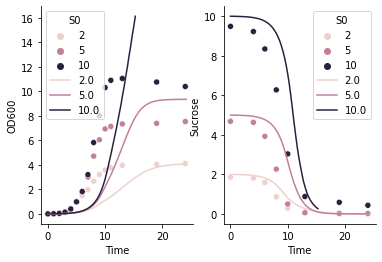

R2 = 0.174 (growth),-10.667 (sucrose)
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 61.0501
Function value obtained: 11.4409
Current minimum: 11.4409
Iteration No: 2 started. Evaluating function at random point.
mu: 2.260e-04,rho: 2.340e+02,ksuc: 5.332e-01, m 0.000e+00


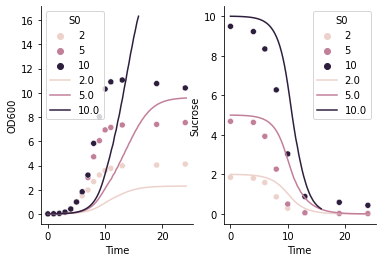

R2 = 0.226 (growth),-10.128 (sucrose)
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 53.4855
Function value obtained: 11.3168
Current minimum: 11.3168
Iteration No: 3 started. Evaluating function at random point.
mu: 1.296e-04,rho: 1.710e+02,ksuc: 9.315e-01, m 0.000e+00


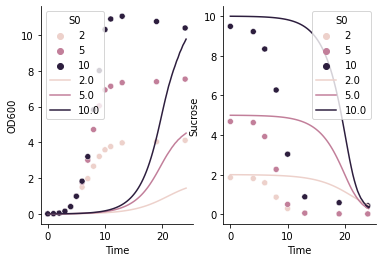

R2 = -0.683 (growth),-16.828 (sucrose)
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 37.4434
Function value obtained: 16.5622
Current minimum: 11.3168
Iteration No: 4 started. Evaluating function at random point.
mu: 4.869e-04,rho: 2.610e+02,ksuc: 7.350e-01, m 0.000e+00


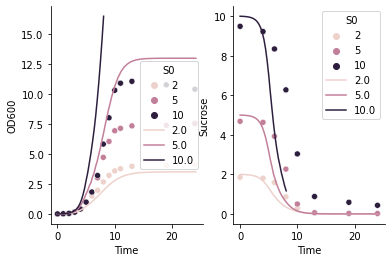

R2 = -0.610 (growth),-5.645 (sucrose)
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 89.1123
Function value obtained: 9.5508
Current minimum: 9.5508
Iteration No: 5 started. Evaluating function at random point.
mu: 1.855e-04,rho: 2.150e+02,ksuc: 6.811e-01, m 0.000e+00


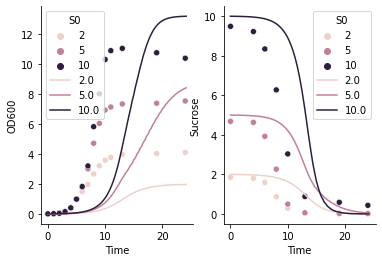

R2 = -0.462 (growth),-13.456 (sucrose)
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 74.5974
Function value obtained: 14.6351
Current minimum: 9.5508
Iteration No: 6 started. Evaluating function at random point.
mu: 2.081e-04,rho: 2.810e+02,ksuc: 6.439e-01, m 0.000e+00


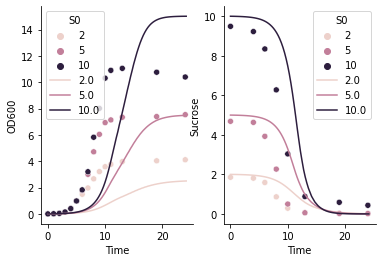

R2 = -0.390 (growth),-11.258 (sucrose)
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 69.1852
Function value obtained: 13.5958
Current minimum: 9.5508
Iteration No: 7 started. Evaluating function at random point.
mu: 3.066e-04,rho: 2.330e+02,ksuc: 6.011e-01, m 0.000e+00


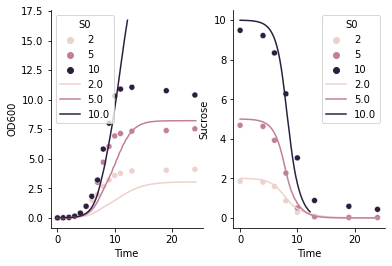

R2 = 0.303 (growth),-6.678 (sucrose)
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 55.8398
Function value obtained: 9.3368
Current minimum: 9.3368
Iteration No: 8 started. Evaluating function at random point.
mu: 2.843e-04,rho: 2.310e+02,ksuc: 3.222e-01, m 0.000e+00


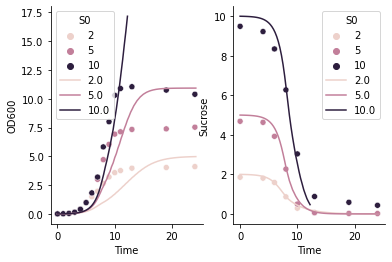

R2 = 0.195 (growth),-6.933 (sucrose)
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 79.8307
Function value obtained: 8.9177
Current minimum: 8.9177
Iteration No: 9 started. Evaluating function at random point.
mu: 3.365e-04,rho: 1.990e+02,ksuc: 2.028e-01, m 0.000e+00


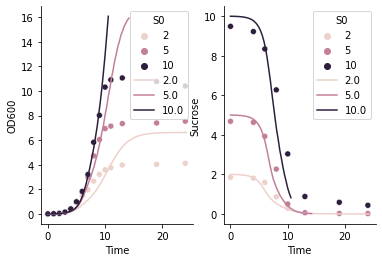

R2 = -0.282 (growth),-6.319 (sucrose)
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 61.0888
Function value obtained: 9.6973
Current minimum: 8.9177
Iteration No: 10 started. Evaluating function at random point.
mu: 3.095e-04,rho: 2.050e+02,ksuc: 2.781e-01, m 0.000e+00
error


Traceback (most recent call last):
  File "/home/jsakkos/miniconda3/envs/nufeb/lib/python3.9/runpy.py", line 188, in _run_module_as_main
Traceback (most recent call last):
  File "/home/jsakkos/miniconda3/envs/nufeb/lib/python3.9/runpy.py", line 188, in _run_module_as_main
Traceback (most recent call last):
  File "/home/jsakkos/miniconda3/envs/nufeb/lib/python3.9/runpy.py", line 188, in _run_module_as_main
    mod_name, mod_spec, code = _get_module_details(mod_name, _Error)
  File "/home/jsakkos/miniconda3/envs/nufeb/lib/python3.9/runpy.py", line 111, in _get_module_details
    mod_name, mod_spec, code = _get_module_details(mod_name, _Error)
  File "/home/jsakkos/miniconda3/envs/nufeb/lib/python3.9/runpy.py", line 111, in _get_module_details
    mod_name, mod_spec, code = _get_module_details(mod_name, _Error)
  File "/home/jsakkos/miniconda3/envs/nufeb/lib/python3.9/runpy.py", line 111, in _get_module_details
    __import__(pkg_name)
    __import__(pkg_name)
  File "/home/jsakkos/mini

KeyboardInterrupt: 

In [55]:
mu_min = float('1e-4')
mu_max = float('5e-4')
rho_min = 150
rho_max = 307
k_suc_min = float('1e-1')
k_suc_max = float('1e0')
m_min = 0
m_max = float('1e-9')
checkpoint_saver = CheckpointSaver(r"/home/jsakkos/nufeb-cyano-e-coli/checkpoints/ecw.pkl", compress=9)
bounds = [(mu_min,mu_max),(rho_min,rho_max),(k_suc_min,k_suc_max)]
n_calls = 100
gp_res = gp_minimize(func, bounds, n_calls=n_calls,n_initial_points=10,
                     random_state=5348,verbose=True,
                     callback=[tqdm_skopt(total=n_calls, desc="Gaussian Process"),checkpoint_saver])

In [41]:
optimizer = Optimizer(
    dimensions=[Real(float('5e-5'), float('1e-3')), 
                Real(150, 307),
                Real(float('1e-1'),float('1.5e1'))],
    random_state=1,
    base_estimator='gp'
)

for i in range(10):
    x = optimizer.ask(n_points=8)  # x is a list of n_points points
    y = Parallel(n_jobs=8)(delayed(func)(v) for v in x)  # evaluate points in parallel
    optimizer.tell(x, y)


ERROR! Session/line number was not unique in database. History logging moved to new session 78
mu: 1.056e-04,rho: 1.901e+02,ksuc: 7.236e+00, m 0.000e+00
R2 = -1.279 (growth),-23.062 (sucrose)
Error: /home/jsakkos/NUFEB/786679/786679 : No such file or directory
mu: 7.308e-05,rho: 2.971e+02,ksuc: 1.246e+01, m 0.000e+00
R2 = -1.324 (growth),-23.483 (sucrose)
Error: /home/jsakkos/NUFEB/133388/133388 : No such file or directory


KeyboardInterrupt: 

In [ ]:
optimizer.get_result()

In [ ]:
plot_convergence(optimizer.get_result(),yscale='log')

IndexError: list index out of range

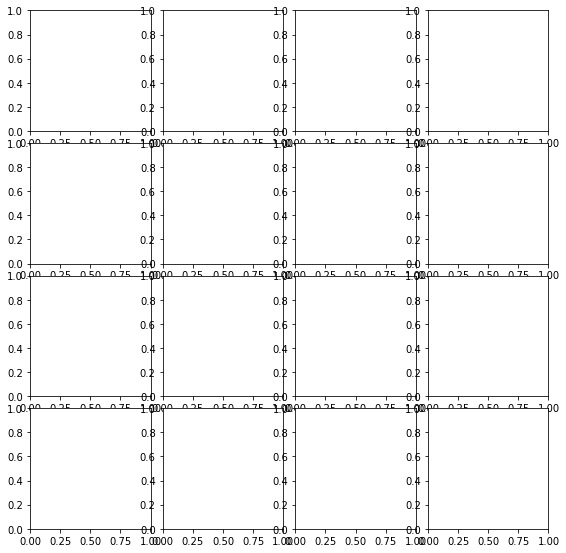

In [36]:
plot_objective(optimizer.get_result())

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

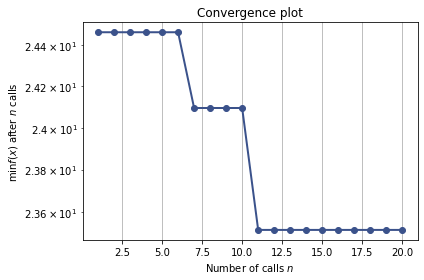

In [20]:
plot_convergence(gp_res,yscale='log')

array([[<AxesSubplot:xlabel='$\\mu$', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='$\\rho$'>,
        <AxesSubplot:xlabel='$\\rho$', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='$K_{sucrose}$'>, <AxesSubplot:>,
        <AxesSubplot:xlabel='$K_{sucrose}$', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='$\\mu$', ylabel='Maintenance'>,
        <AxesSubplot:xlabel='$\\rho$'>,
        <AxesSubplot:xlabel='$K_{sucrose}$'>,
        <AxesSubplot:xlabel='Maintenance', ylabel='Partial dependence'>]],
      dtype=object)

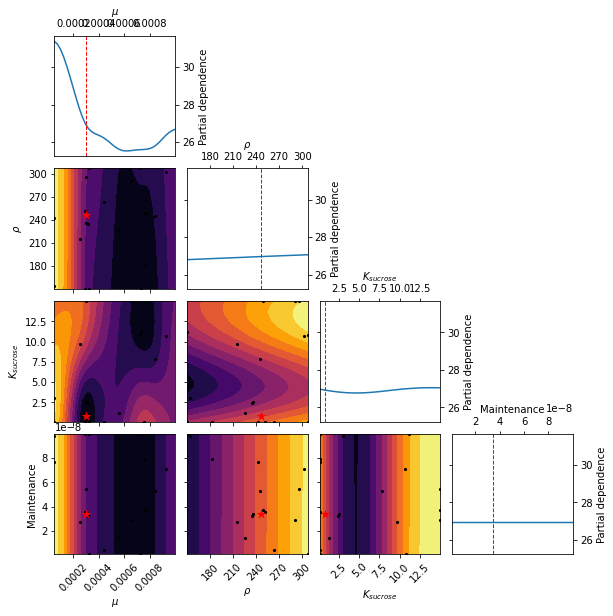

In [21]:
plot_objective(gp_res,dimensions=[r'$\mu$',r'$\rho$',r'$K_{sucrose}$','Maintenance'],cmap='inferno')

In [23]:
gp_res.x

[0.0002987634322954705, 246, 0.7403717207986527, 3.417120774805238e-08]

mu: 2.988e-04,rho: 2.460e+02,ksuc: 7.404e-01, m 3.417e-08


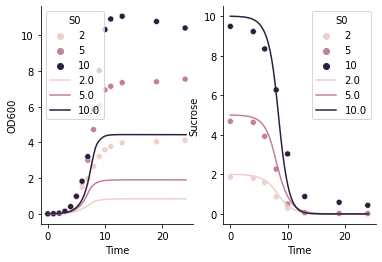

R2 = 0.181 (growth),-6.690 (sucrose)


23.657706749880585

In [22]:
func(gp_res.x,growth=growthData,sucrose=expSucrose)